# Linear Regression

Let's set some setting for this Jupyter Notebook.

In [1]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Now, let's import the `LinearRegression` model from the `pymc-learn` package.

In [2]:
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc0


## Step 1: Prepare the data
Generate synthetic data.

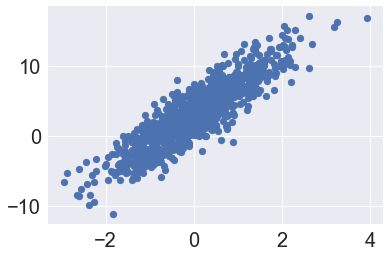

In [3]:
X = np.random.randn(1000, 1)
noise = 2 * np.random.randn(1000, 1)
slope = 4
intercept = 3
y = slope * X + intercept + noise
y = np.squeeze(y)

fig, ax = plt.subplots()
ax.scatter(X, y);

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Step 2: Instantiate a model

In [5]:
model = LinearRegression()

## Step 3: Perform Inference

In [6]:
model.fit(X_train, y_train)

Average Loss = 1,512:  14%|█▍        | 27662/200000 [00:14<01:29, 1923.95it/s]
Convergence archived at 27700
Interrupted at 27,699 [13%]: Average Loss = 3,774.9


LinearRegression()

## Step 4: Diagnose convergence

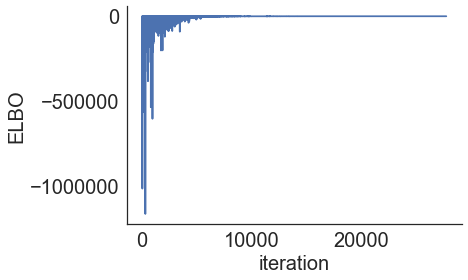

In [7]:
model.plot_elbo()

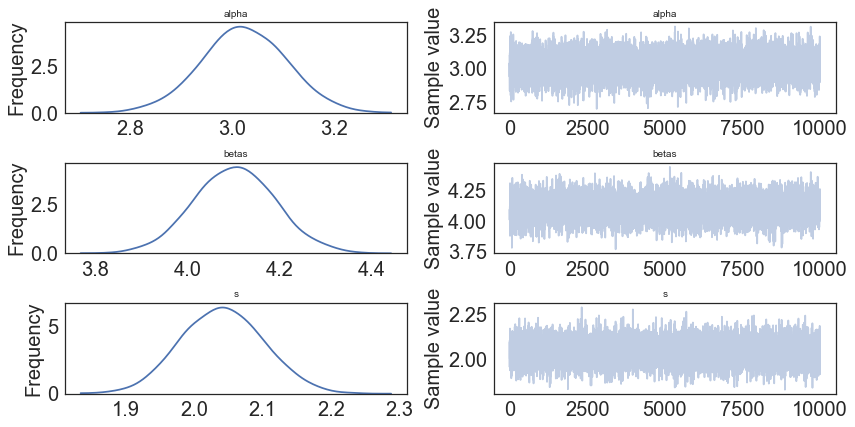

In [8]:
pm.traceplot(model.trace);

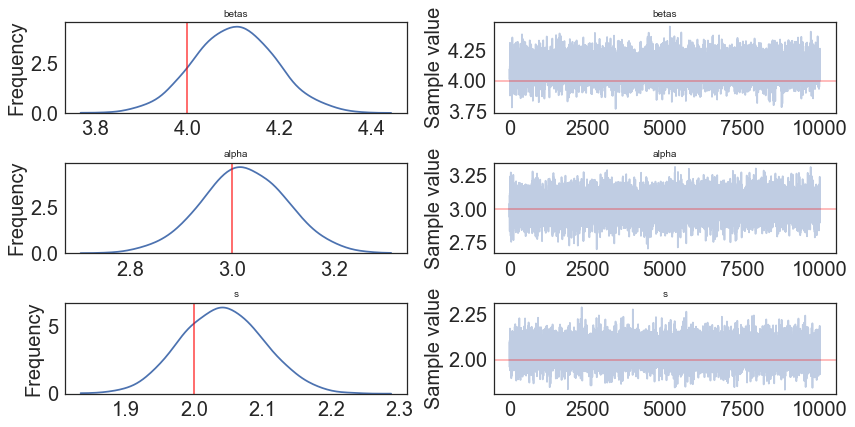

In [9]:
pm.traceplot(model.trace, lines = {"betas": slope, 
                                 "alpha": intercept, 
                                 "s": 2}, 
             varnames=["betas", "alpha", "s"]);

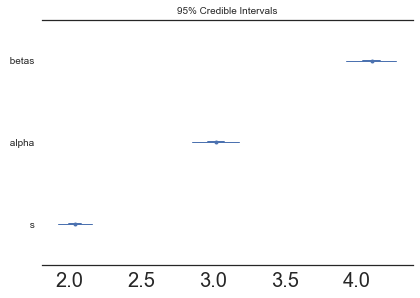

In [10]:
pm.forestplot(model.trace, varnames=["betas", "alpha", "s"]);

## Step 5: Critize the model

In [11]:
pm.summary(model.trace, varnames=["betas", "alpha", "s"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
betas__0_0,4.103347,0.087682,0.000780,3.927048,4.274840
alpha__0,3.023007,0.084052,0.000876,2.851976,3.184953
s,2.041354,0.060310,0.000535,1.926967,2.160172


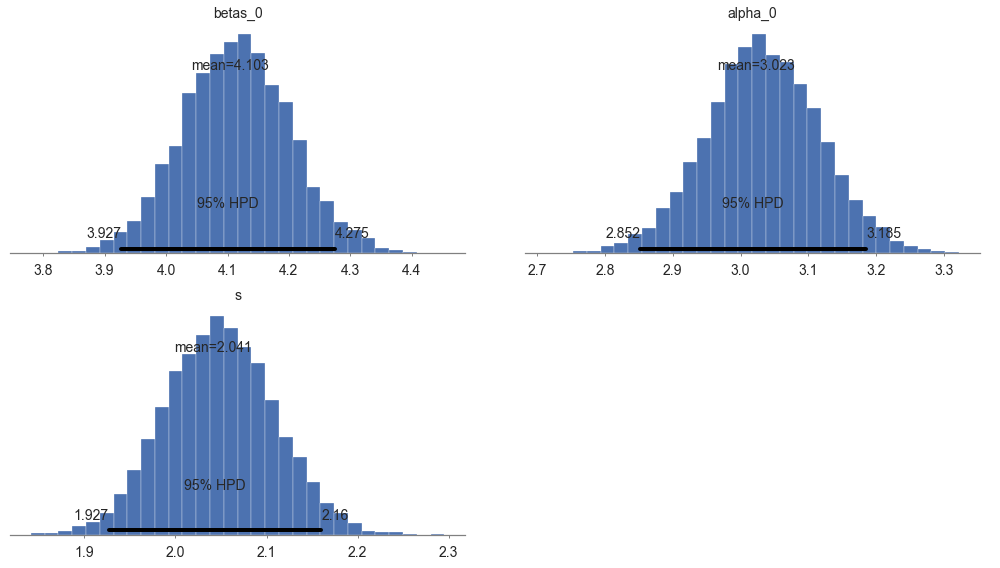

In [12]:
pm.plot_posterior(model.trace, varnames=["betas", "alpha", "s"], 
                 figsize = [14, 8]);

In [13]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["betas", "alpha", "s"],
              "Parameter-Learned (Mean Value)": [float(model.trace["betas"].mean(axis=0)), 
                               float(model.trace["alpha"].mean(axis=0)), 
                               float(model.trace["s"].mean(axis=0))],
              "True value": [slope, intercept, 2]})

,Parameter,Parameter-Learned (Mean Value),True value
0,betas,4.103347,4
1,alpha,3.023007,3
2,s,2.041354,2


## Step 6: Use the model for prediction

In [14]:
y_predict = model.predict(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 2453.39it/s]


In [15]:
model.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2694.94it/s]


0.77280797745735419

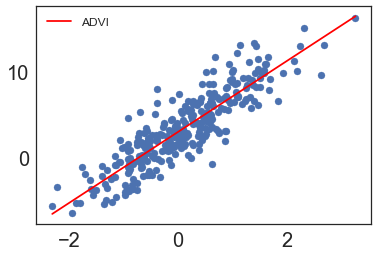

In [17]:
max_x = max(X_test)
min_x = min(X_test)

slope_learned = model.summary['mean']['betas__0_0']
intercept_learned = model.summary['mean']['alpha__0']
fig1, ax1 = plt.subplots()
ax1.scatter(X_test, y_test)
ax1.plot([min_x, max_x], [slope_learned*min_x + intercept_learned, slope_learned*max_x + intercept_learned], 'r', label='ADVI')
ax1.legend();

In [18]:
model.save('pickle_jar/linear_model')

#### Use already trained model for prediction

In [19]:
model_new = LinearRegression()

In [20]:
model_new.load('pickle_jar/linear_model')

In [21]:
model_new.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2407.83it/s]


0.77374690833817472

## MCMC

In [22]:
model2 = LinearRegression()
model2.fit(X_train, y_train, inference_type='nuts')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s_log__, betas, alpha]
100%|██████████| 2500/2500 [00:02<00:00, 1119.39it/s]


LinearRegression()

### Diagnose convergence

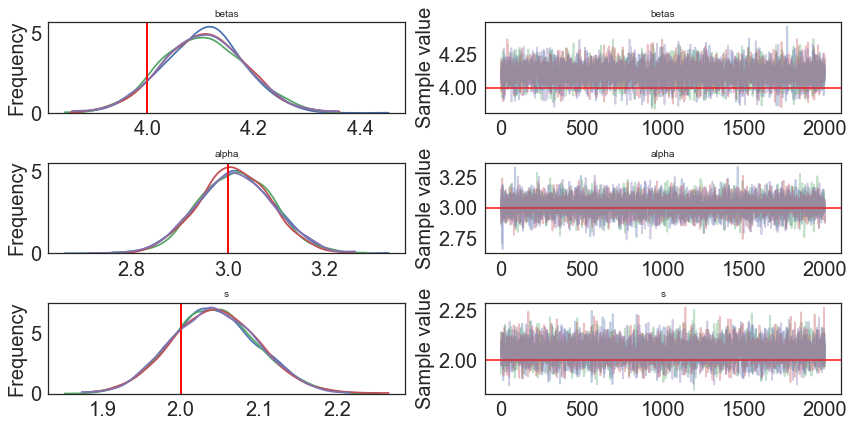

In [23]:
pm.traceplot(model2.trace, lines = {"betas": slope, 
                                 "alpha": intercept, 
                                 "s": 2}, 
             varnames=["betas", "alpha", "s"]);

In [24]:
pm.gelman_rubin(model2.trace, varnames=["betas", "alpha", "s"])

{'betas': array([[ 0.99983746]]),
 'alpha': array([ 0.99995935]),
 's': 0.99993398539611289}

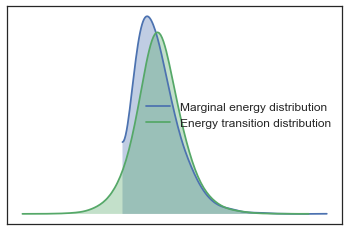

In [25]:
pm.energyplot(model2.trace);

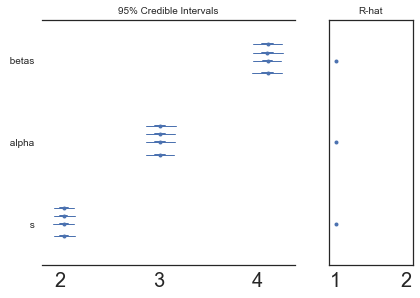

In [26]:
pm.forestplot(model2.trace, varnames=["betas", "alpha", "s"]);

### Criticize the model

In [27]:
pm.summary(model2.trace, varnames=["betas", "alpha", "s"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betas__0_0,4.104122,0.077358,0.000737,3.953261,4.255527,10544.412041,0.999837
alpha__0,3.014851,0.076018,0.000751,2.871447,3.167465,11005.925586,0.999959
s,2.043248,0.055253,0.000469,1.937634,2.152135,11918.920019,0.999934


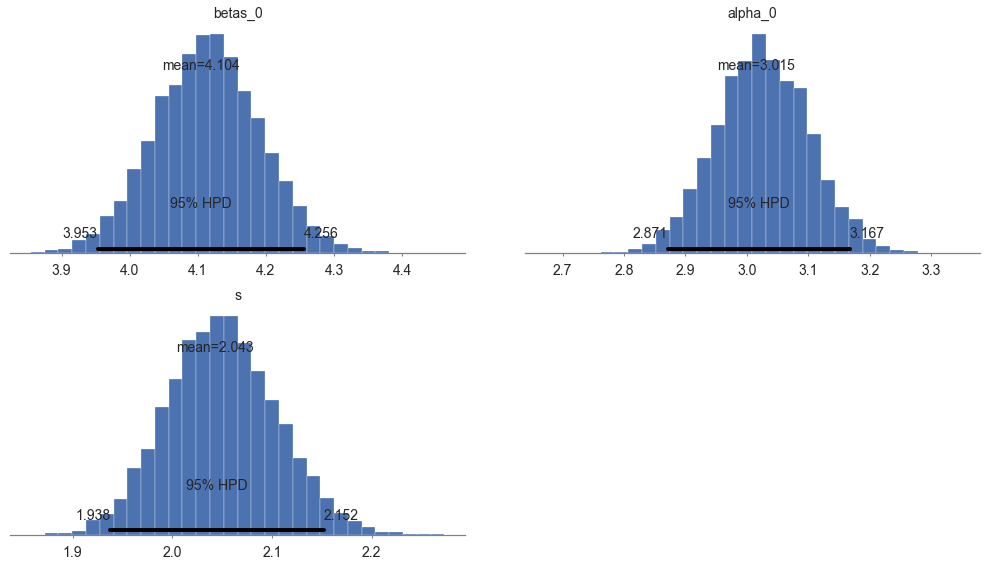

In [28]:
pm.plot_posterior(model2.trace, varnames=["betas", "alpha", "s"], 
                 figsize = [14, 8]);

### Use the model for prediction

In [29]:
y_predict2 = model2.predict(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 2430.09it/s]


In [30]:
model2.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2517.14it/s]


0.77203138547620576

## Compare the two methods

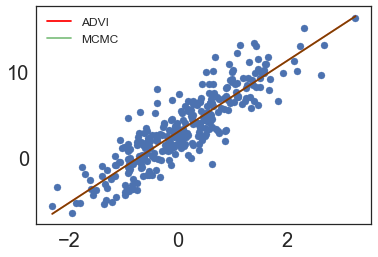

In [31]:
max_x = max(X_test)
min_x = min(X_test)

slope_learned = model.summary['mean']['betas__0_0']
intercept_learned = model.summary['mean']['alpha__0']

slope_learned2 = model2.summary['mean']['betas__0_0']
intercept_learned2 = model2.summary['mean']['alpha__0']

fig1, ax1 = plt.subplots()
ax1.scatter(X_test, y_test)
ax1.plot([min_x, max_x], [slope_learned*min_x + intercept_learned, slope_learned*max_x + intercept_learned], 'r', label='ADVI')
ax1.plot([min_x, max_x], [slope_learned2*min_x + intercept_learned2, slope_learned2*max_x + intercept_learned2], 'g', label='MCMC', alpha=0.5)
ax1.legend();

In [32]:
model2.save('pickle_jar/linear_model2')
model2_new = LinearRegression()
model2_new.load('pickle_jar/linear_model2')
model2_new.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2510.66it/s]


0.77268267975638316

## Multiple predictors

In [33]:
num_pred = 2
X = np.random.randn(1000, num_pred)
noise = 2 * np.random.randn(1000,)
y = X.dot(np.array([4, 5])) + 3 + noise
y = np.squeeze(y)

In [34]:
model_big = LinearRegression()

In [35]:
model_big.fit(X, y)

Average Loss = 2,101.7:  16%|█▋        | 32715/200000 [00:16<01:27, 1920.43it/s]
Convergence archived at 32800
Interrupted at 32,799 [16%]: Average Loss = 7,323.3


LinearRegression()

In [36]:
model_big.summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.907646,0.067021,0.000569,2.779519,3.038211
betas__0_0,4.051214,0.066629,0.000735,3.921492,4.181938
betas__0_1,5.038803,0.065906,0.000609,4.907503,5.166529
s,1.929029,0.046299,0.000421,1.836476,2.016829
